# Kernel methods for a 2 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 \Delta u + C_2 u^3 = f, & \boldsymbol{x} \in [0,1]^d \\ u = 0, &\boldsymbol{x} \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian. 

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth

### Reference Solution

$$u(\boldsymbol{x}) = \exp\left(-\frac{1}{1-r^2}\right)\left[\sin(\pi x_1)\sin(\pi x_2)+4\sin(4\pi x_1)\sin(4 \pi x_2)\right] 1_{\boldsymbol{x} \in (0,1)^2}$$
where $r = \sqrt{(2x_1-1)^2+(2x_2-1)^2}$

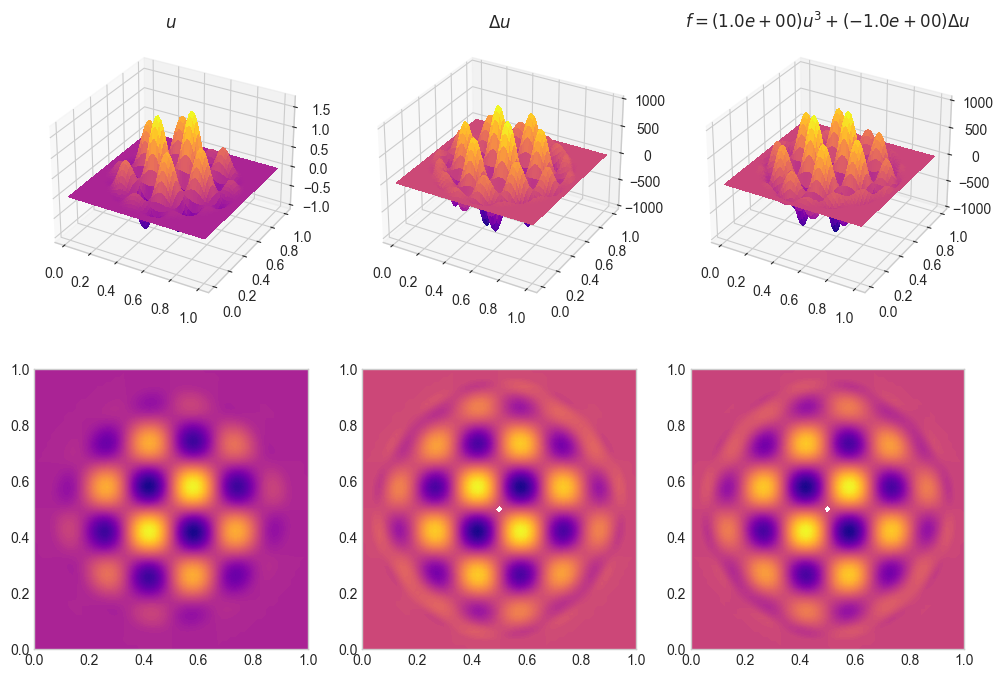

In [24]:
C1 = 1.
C2 = -1.
def u(x):
    x1,x2 = x[:,0],x[:,1]
    y = torch.zeros_like(x1)
    r = torch.sqrt((2*x1-1)**2+(2*x2-1)**2)
    b = r<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = torch.sin(torch.pi*x1[b])*torch.sin(torch.pi*x2[b])
    t3 = 4*torch.sin(6*torch.pi*x1[b])*torch.sin(6*torch.pi*x2[b])
    y[b] = t1*(t2+t3)
    return y
def u_laplace(x):
    x1g,x2g = x[:,0].clone().requires_grad_(),x[:,1].clone().requires_grad_()
    xg = torch.hstack([x1g[:,None],x2g[:,None]])
    yg = u(xg)
    grad_outputs = torch.ones_like(yg,requires_grad=False)
    yp1g = torch.autograd.grad(yg,x1g,grad_outputs,create_graph=True)[0]
    yp1p1g = torch.autograd.grad(yp1g,x1g,grad_outputs,create_graph=True)[0]
    yp2g = torch.autograd.grad(yg,x2g,grad_outputs,create_graph=True)[0]
    yp2p2g = torch.autograd.grad(yp2g,x2g,grad_outputs,create_graph=True)[0]
    return (yp1p1g+yp2p2g).detach()
def f(x):
    return C1*u(x)**3+C2*u_laplace(x)
x1dticks = torch.linspace(0,1,65,dtype=float)
x1mesh,x2mesh = torch.meshgrid(x1dticks,x1dticks,indexing="ij")
x1ticks,x2ticks = x1mesh.flatten(),x2mesh.flatten()
xticks = torch.hstack([x1ticks[:,None],x2ticks[:,None]])
ymesh = u(xticks).reshape(x1mesh.shape)
ylmesh = u_laplace(xticks).reshape(x1mesh.shape)
fmesh = f(xticks).reshape(x1mesh.shape)
fig = pyplot.figure(figsize=(12,8))
ax = np.empty((2,3),dtype=object)
_gs = gridspec.GridSpec(2,3) 
for i in range(3): ax[0,i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(3): ax[1,i] = fig.add_subplot(_gs[1,i])
ax[0,0].plot_surface(x1mesh,x2mesh,ymesh,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma)
ax[1,0].contourf(x1mesh,x2mesh,ymesh,antialiased=False,cmap=cm.plasma,levels=100)
ax[0,1].plot_surface(x1mesh,x2mesh,ylmesh,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma);
ax[1,1].contourf(x1mesh,x2mesh,ylmesh,antialiased=False,cmap=cm.plasma,levels=100)
ax[0,2].plot_surface(x1mesh,x2mesh,fmesh,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma);
ax[1,2].contourf(x1mesh,x2mesh,fmesh,antialiased=False,cmap=cm.plasma,levels=100)
ax[0,0].set_title(r"$u$")
ax[0,1].set_title(r"$\Delta u$")
ax[0,2].set_title(r"$f = (%.1e) u^3 + (%.1e) \Delta u$"%(C1,C2));

## PDE Setup

In [41]:
ns = torch.tensor([ # number of collocation points
    2**10, # on the interior
    2**8, # boundary top-bottom
    2**8, # boundary left-right
],dtype=int)
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True,True], # interior points (not projected to the 0 boundary)
    [True,False], # boundary points top-bottom i.e. x_2=0 or x_2=1
    [False,True] # boundary points left-right i.e. x_1=0 or x_1=1
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0,0]],dtype=int), # u
        torch.tensor([[2,0],[0,2]],dtype=int), # laplacian u
    ],
    [ # boundary top-bottom
        torch.tensor([[0,0]],dtype=int) # u
    ],
    [ # boundary left-right 
        torch.tensor([[0,0]],dtype=int) # u
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # u 
        torch.ones(2,dtype=float) # laplacian u
    ],
    [ # boundary top-bottom
        torch.ones(1,dtype=float) # u
    ],
    [ # boundary left-right
        torch.ones(1,dtype=float) # u
    ]
]

In [42]:
def pde_lhs(ly_i, ly_b_tb, ly_b_lr):
    u_i,u_laplace_i = ly_i
    u_b_tb = ly_b_tb[0] 
    u_b_lr = ly_b_lr[0]
    lhs_i = C1*u_i**3+C2*u_laplace_i
    lhs_b_tb = u_b_tb
    lhs_b_lr = u_b_lr
    return lhs_i,lhs_b_tb,lhs_b_lr
def pde_rhs(x_i, x_b_tb, x_b_lr):
    y_i = f(x_i)
    y_b_tb = torch.zeros(len(x_b_tb),dtype=float)
    y_b_lr = torch.zeros(len(x_b_lr),dtype=float)
    return y_i,y_b_tb,y_b_lr

## Kernel Interpolant 

### Construction

In [43]:
noise = 1e-8
lattice = qp.Lattice(dimension=2,seed=7) # collocation points
kernel = qp.KernelGaussian(dimension=2,lengthscales=1e-2,alpha=4,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(lattice,kernel,llbetas,llcs,noise,ns,us) # kernel interpolant

### PDE Optimization

In [44]:
y,losses_opt,rerrors_opt,times_opt = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 8,
    solver = "CHOL",
    verbose = True)

	iter (8 max)        loss           
	1                   2.16e+02       
	2                   3.91e-01       
	3                   2.07e-04       
	4                   7.52e-07       
	5                   7.50e-07       
	6                   7.35e-07       
	7                   7.58e-07       
	8                   7.86e-07       


### Fitting

In [47]:
coeffs = ki._solve(y) 
#coeffs,rerrors_fit,times_fit = ki.pcg(y,precond=True)
kvec = ki.get_new_left_full_gram_matrix(xticks)
yhatmesh = (kvec@coeffs).reshape(x1mesh.shape)
print("yhatmesh.shape = %s"%str(tuple(yhatmesh.shape)))
print("L2 Rel Error Gauss: %.1e"%(torch.linalg.norm(yhatmesh-ymesh)/torch.linalg.norm(ymesh)))

yhatmesh.shape = (65, 65)
L2 Rel Error Gauss: 1.0e-03


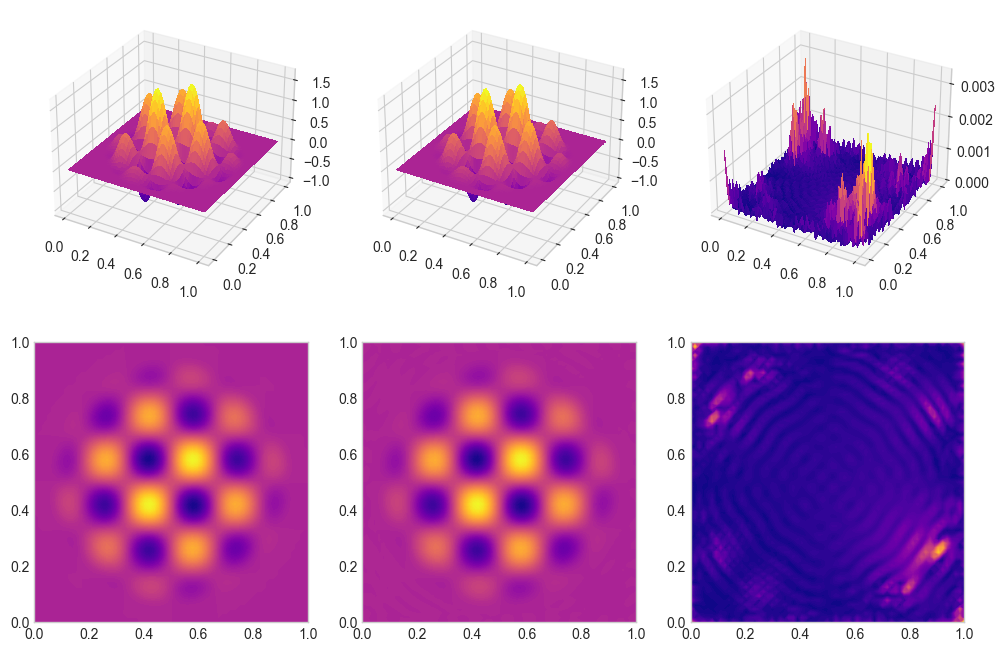

In [48]:
fig = pyplot.figure(figsize=(12,8))
ax = np.empty((2,3),dtype=object)
_gs = gridspec.GridSpec(2,3) 
for i in range(3): ax[0,i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(3): ax[1,i] = fig.add_subplot(_gs[1,i])
ax[0,0].plot_surface(x1mesh,x2mesh,ymesh,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma)    
ax[1,0].contourf(x1mesh,x2mesh,ymesh,antialiased=False,cmap=cm.plasma,levels=100)
ax[0,1].plot_surface(x1mesh,x2mesh,yhatmesh,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma)    
ax[1,1].contourf(x1mesh,x2mesh,yhatmesh,antialiased=False,cmap=cm.plasma,levels=100)
yerr = torch.abs(yhatmesh-ymesh)
ax[0,2].plot_surface(x1mesh,x2mesh,yerr,cstride=1,rstride=1,antialiased=False,cmap=cm.plasma)    
ax[1,2].contourf(x1mesh,x2mesh,yerr,antialiased=False,cmap=cm.plasma,levels=100);